In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
df = pd.read_csv('/content/coarse-and-fine-grained-ner-dataset.csv')

In [3]:
df.head()

,Text,Organ Entities,Descriptor Entities,Coarse-grained Annotation,Fine-grained Annotation
0,"grandes feuilles opposées, oblongues-elliptiq...","['bouton', 'pédicelle', 'corolle', 'tube', 'fe...","['fermée', 'pubes-cents', 'cunéiformes', 'vent...","[(650, 661, 'DESCRIPTEUR'), (968, 977, 'DESCRI...","[(650, 661, 'DESCRIPTEUR'), (395, 407, 'DISPOS..."
1,"feuilles opposées, groupées à l'extrémité des...","['limbe', 'style', 'filets', 'rameaux', 'sépal...","['elliptiques', '1 cm de longueur', 'extrorses...","[(609, 618, 'DESCRIPTEUR'), (129, 144, 'DESCRI...","[(609, 618, 'DESCRIPTEUR'), (73, 80, 'FORME'),..."
2,"feuilles opposées, obovées oblongues, arrondi...","['corolle', 'limbe', 'ovaire', 'lobes', 'base'...","['cunéiforme', '10,5 mm de longueur', 'long', ...","[(60, 64, 'ORGANE'), (196, 205, 'DESCRIPTEUR')...","[(60, 64, 'ORGANE'), (180, 187, 'ORGANE'), (11..."
3,"arbustes petites feuilles opposées, groupées...","['anthères', 'pétales', 'tube', 'feuilles', 's...","['secondaires', 'accusé', 'saillantes', 'apicu...","[(949, 959, 'DESCRIPTEUR'), (88, 105, 'DESCRIP...","[(949, 959, 'DESCRIPTEUR'), (88, 105, 'DESCRIP..."
4,"arbustes feuilles opposées ou alternes, obla...","['base', 'nervure', 'feuilles', 'arbustes', 'l...","['proéminente', 'décurrente', 'alternes', 'obl...","[(140, 150, 'DESCRIPTEUR'), (32, 40, 'DESCRIPT...","[(42, 54, 'FORME'), (119, 129, 'FORME'), (1, 9..."


## First step :

We are going to create tagged words.
In "Coarse-grained Annotation" we have tuples each one has : (start position, end position, TAG ).
In text we are going to initialize all words to "O" after processing using the start and end position of the tags, we will split the text into words and map the tags to words. If a word contains any tagged characters, assign the first non-"O" tag to the word.

In [4]:
import ast

def parse_annotations(annotation_str):
    # Convert string to list of tuples
    return ast.literal_eval(annotation_str)

def generate_ner_tags(text, annotations):
    tags = ["O"] * len(text)

    for start, end, label in annotations:
        tags[start] = label  # Use only the label without prefixes
        for i in range(start + 1, end):
            tags[i] = label  # Use only the label without prefixes

    words = text.split()
    word_tags = []
    current_idx = 0

    for word in words:
        word_start = current_idx
        word_end = current_idx + len(word)
        word_tag = tags[word_start:word_end]

        if all(tag == "O" for tag in word_tag):
            word_tags.append((word, "O"))
        else:
            non_o_tags = [tag for tag in word_tag if tag != "O"]
            word_tags.append((word, non_o_tags[0]))  # Use the first tag found

        current_idx = word_end + 1  # Move index to the next word

    return word_tags

tagged_sentences = []

for index, row in df.iterrows():
    text = row["Text"]
    annotations = parse_annotations(row["Fine-grained Annotation"])  # Parse annotation string
    word_tags = generate_ner_tags(text, annotations)
    tagged_sentences.append((word_tags))


In [5]:
X = []
Y = []

for sentence in tagged_sentences:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:
        X_sentence.append(entity[0].lower())
        Y_sentence.append(entity[1])

    X.append(X_sentence)
    Y.append(Y_sentence)

In [6]:
print("Total number of sentences: {}".format(len(X)))

Total number of sentences: 838


In [7]:
vocab = set([word.lower() for sentence in X for word in sentence])
num_words = len(set([word.lower() for sentence in X for word in sentence]))

print("Vocabulary size: {}".format(num_words))

Vocabulary size: 12601


In [8]:
tags = set([word for sentence in Y for word in sentence])
num_tags = len(set([word for sentence in Y for word in sentence]))

print(tags)

{'O', 'COULEUR', 'POSITION', 'DEVELOPPEMENT', 'SURFACE', 'FORME', 'ORGANE', 'DESCRIPTEUR', 'STRUCTURE', 'DISPOSITION', 'MESURE'}


In [9]:
word_to_ix = {}

for word in vocab:
  if word not in word_to_ix:
    word_to_ix[word] = len(word_to_ix)

In [10]:
tag_to_ix = {}

for tag in tags:
  tag_to_ix[tag] = len(tag_to_ix)

print(tag_to_ix)

{'O': 0, 'COULEUR': 1, 'POSITION': 2, 'DEVELOPPEMENT': 3, 'SURFACE': 4, 'FORME': 5, 'ORGANE': 6, 'DESCRIPTEUR': 7, 'STRUCTURE': 8, 'DISPOSITION': 9, 'MESURE': 10}


In [11]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long, device = 'cuda')
from sklearn.model_selection import train_test_split

In [12]:
from sklearn.model_selection import train_test_split

SPLIT_SIZE = 0.2

# split entire data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=SPLIT_SIZE, random_state=4)

# split training data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=SPLIT_SIZE, random_state=4)

In [13]:
from collections import Counter

# Initialize a Counter to store the count of each tag
tag_counts = Counter()

# Iterate over tagged sentences
for sentence in tagged_sentences:
    for _, tag in sentence:  # Extract each tag
        tag_counts[tag] += 1

# Print the counts of each tag
for tag, count in tag_counts.items():
    print(f"{tag}: {count}")

O: 99840
ORGANE: 37027
DISPOSITION: 1076
DESCRIPTEUR: 13257
FORME: 6084
MESURE: 3738
SURFACE: 3862
POSITION: 1396
COULEUR: 1519
STRUCTURE: 1272
DEVELOPPEMENT: 47


In [14]:
import torch
print("GPU available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")



GPU available: True
Device name: Tesla T4


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare sequences
def prepare_sequences(sequences, word_to_ix, tag_to_ix):
    prepared_sequences = []
    prepared_tags = []

    for seq, tags in zip(sequences[0], sequences[1]):
        prepared_sequences.append(prepare_sequence(seq, word_to_ix))
        prepared_tags.append(prepare_sequence(tags, tag_to_ix))

    return prepared_sequences, prepared_tags

X_train, Y_train = prepare_sequences((X_train, Y_train), word_to_ix, tag_to_ix)
X_val, Y_val = prepare_sequences((X_val, Y_val), word_to_ix, tag_to_ix)
X_test, Y_test = prepare_sequences((X_test, Y_test), word_to_ix, tag_to_ix)

# Pad sequences
def pad_data(sequences, tags):
    seq_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    tags_padded = pad_sequence(tags, batch_first=True, padding_value=tag_to_ix["O"])
    return seq_padded, tags_padded

X_train, Y_train = pad_data(X_train, Y_train)
X_val, Y_val = pad_data(X_val, Y_val)
X_test, Y_test = pad_data(X_test, Y_test)

In [16]:
import torch
import torch.nn as nn

class VanillaLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VanillaLSTM, self).__init__()
        self.hidden_size = hidden_size

        # Forget gate weights
        self.Wxf = nn.Linear(input_size, hidden_size)
        self.Whf = nn.Linear(hidden_size, hidden_size)

        # Input gate weights
        self.Wxi = nn.Linear(input_size, hidden_size)
        self.Whi = nn.Linear(hidden_size, hidden_size)

        # Candidate cell state weights
        self.Wxc = nn.Linear(input_size, hidden_size)
        self.Whc = nn.Linear(hidden_size, hidden_size)

        # Output gate weights
        self.Wxo = nn.Linear(input_size, hidden_size)
        self.Who = nn.Linear(hidden_size, hidden_size)

        # Fully connected layer for output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size, seq_len, input_size = x.size()

        # Initialize hidden state (h_t) and cell state (c_t)
        h_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
        c_t = torch.zeros(batch_size, self.hidden_size).to(x.device)

        outputs = []
        for t in range(seq_len):
            x_t = x[:, t, :]  # Input at time step t

            # Forget gate
            f_t = torch.sigmoid(self.Wxf(x_t) + self.Whf(h_t))

            # Input gate
            i_t = torch.sigmoid(self.Wxi(x_t) + self.Whi(h_t))

            # Candidate cell state
            c_hat_t = torch.tanh(self.Wxc(x_t) + self.Whc(h_t))

            # Update cell state
            c_t = f_t * c_t + i_t * c_hat_t

            # Output gate
            o_t = torch.sigmoid(self.Wxo(x_t) + self.Who(h_t))

            # Update hidden state
            h_t = o_t * torch.tanh(c_t)

            outputs.append(h_t.unsqueeze(1))  # Save the hidden state for each time step

        lstm_out = torch.cat(outputs, dim=1)  # Combine outputs for all time steps
        logits = self.fc(lstm_out)  # Compute predictions
        return logits



In [48]:

class StackedVanillaLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(StackedVanillaLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        # Create LSTM layers
        self.lstm_layers = nn.ModuleList([
            VanillaLSTM(
                input_size if i == 0 else hidden_size,
                hidden_size,
                hidden_size
            ) for i in range(num_layers)
        ])

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Process through each LSTM layer
        current_input = x

        for layer in self.lstm_layers:
            current_input = layer(current_input)

        # Apply final linear layer to each time step
        output = self.fc(current_input)
        return output


In [50]:
class LSTMTaggerWithVanillaLSTM(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim, hidden_dim):
        super(LSTMTaggerWithVanillaLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = VanillaLSTM(embedding_dim, hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, x):
        embeds = self.embedding(x)  # Shape: (batch_size, seq_len, embedding_dim)
        lstm_out = self.lstm(embeds)  # Shape: (batch_size, seq_len, hidden_dim)
        logits = self.fc(lstm_out)  # Shape: (batch_size, seq_len, tagset_size)
        return logits






In [51]:
class LSTMTaggerWithStackedVanillaLSTM(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim, hidden_dim, num_layers):
        super(LSTMTaggerWithStackedVanillaLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = StackedVanillaLSTM(embedding_dim, hidden_dim, hidden_dim, num_layers)
        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, x):
        embeds = self.embedding(x)  # Shape: (batch_size, seq_len, embedding_dim)
        lstm_out = self.lstm(embeds)  # Shape: (batch_size, seq_len, hidden_dim)
        logits = self.fc(lstm_out)  # Shape: (batch_size, seq_len, tagset_size)
        return logits


In [52]:

EMBEDDING_DIM = 300
HIDDEN_DIM = 100
NUM_LAYERS = 3  # For stacked LSTM
VOCAB_SIZE = len(word_to_ix)
TAGSET_SIZE = len(tag_to_ix)

In [53]:
single_lstm = LSTMTaggerWithVanillaLSTM(VOCAB_SIZE, TAGSET_SIZE, EMBEDDING_DIM, HIDDEN_DIM).to(device)

stacked_lstm = LSTMTaggerWithStackedVanillaLSTM(VOCAB_SIZE, TAGSET_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS).to(device)


In [54]:

criterion = nn.CrossEntropyLoss()
optimizer_single = optim.Adam(single_lstm.parameters(), lr=0.01)
optimizer_stacked = optim.Adam(stacked_lstm.parameters(), lr=0.01)

In [55]:
def train_model(model, optimizer, X_train, Y_train, X_val, Y_val, num_epochs=60):
    train_loss, val_loss = [], []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        outputs = model(X_train.to(device))
        outputs = outputs.view(-1, TAGSET_SIZE)
        loss = criterion(outputs, Y_train.view(-1).to(device))
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val.to(device))
            val_outputs = val_outputs.view(-1, TAGSET_SIZE)
            val_loss_epoch = criterion(val_outputs, Y_val.view(-1).to(device)).item()
            val_loss.append(val_loss_epoch)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item()}, Val Loss: {val_loss_epoch}")

    return train_loss, val_loss

In [24]:
train_loss_single, val_loss_single = train_model(single_lstm, optimizer_single, X_train, Y_train, X_val, Y_val)

Epoch 1/60, Train Loss: 2.42018723487854, Val Loss: 0.9195478558540344
Epoch 2/60, Train Loss: 0.6922981142997742, Val Loss: 0.6306703090667725
Epoch 3/60, Train Loss: 0.40993380546569824, Val Loss: 0.7069105505943298
Epoch 4/60, Train Loss: 0.4647811949253082, Val Loss: 0.5441932082176208
Epoch 5/60, Train Loss: 0.35229215025901794, Val Loss: 0.4949627220630646
Epoch 6/60, Train Loss: 0.3182086646556854, Val Loss: 0.48534029722213745
Epoch 7/60, Train Loss: 0.3117403984069824, Val Loss: 0.47023922204971313
Epoch 8/60, Train Loss: 0.30194446444511414, Val Loss: 0.4506136476993561
Epoch 9/60, Train Loss: 0.28894004225730896, Val Loss: 0.43423935770988464
Epoch 10/60, Train Loss: 0.2777913510799408, Val Loss: 0.4229329228401184
Epoch 11/60, Train Loss: 0.2697327733039856, Val Loss: 0.415963351726532
Epoch 12/60, Train Loss: 0.2644532322883606, Val Loss: 0.4091929495334625
Epoch 13/60, Train Loss: 0.25896602869033813, Val Loss: 0.39948827028274536
Epoch 14/60, Train Loss: 0.25087001919746

In [ ]:
train_loss_stacked, val_loss_stacked = train_model(stacked_lstm, optimizer_stacked, X_train, Y_train, X_val, Y_val)

Epoch 1/60, Train Loss: 2.5119333267211914, Val Loss: 1.7927651405334473
Epoch 2/60, Train Loss: 1.7435189485549927, Val Loss: 0.9582571387290955


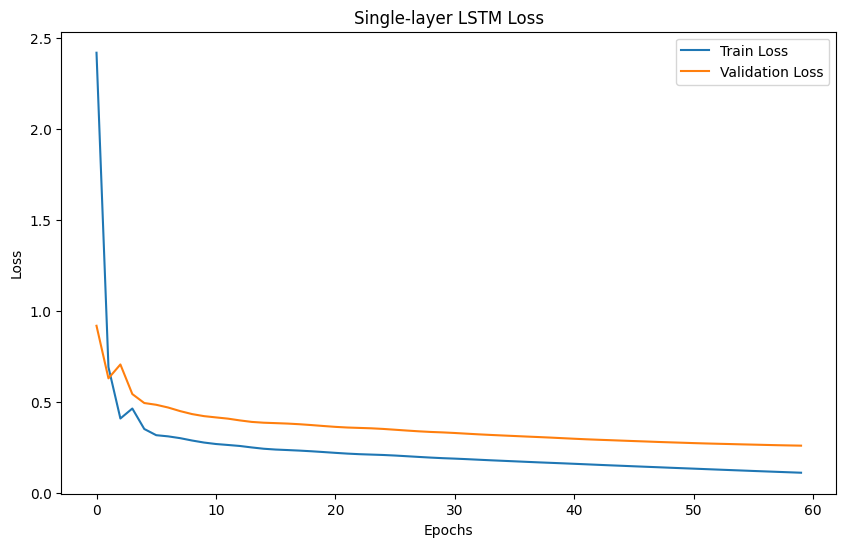

In [25]:
def plot_loss(train_loss, val_loss, title):
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_loss(train_loss_single, val_loss_single, "Single-layer LSTM Loss")
plot_loss(train_loss_stacked, val_loss_stacked, "Stacked LSTM Loss")

In [26]:
def evaluate_model_with_predictions(model, X_test, Y_test, idx_to_tag):
    model.eval()
    with torch.no_grad():
        # Get predictions
        outputs = model(X_test.to(device))
        predictions = torch.argmax(outputs, dim=-1).cpu().numpy()
        labels = Y_test.cpu().numpy()

        # Convert indices to tags
        predicted_tags = [
            [idx_to_tag[pred] for pred in sentence[:len(actual)]]
            for sentence, actual in zip(predictions, labels)
        ]
        actual_tags = [
            [idx_to_tag[label] for label in sentence[:len(actual)]]
            for sentence, actual in zip(labels, labels)
        ]

        # Display a few examples
        for i in range(min(2, len(predicted_tags))):  # Show 5 examples
            print(f"Sentence {i + 1}:")
            print(f"  Predicted: {predicted_tags[i]}")
            print(f"  Actual:    {actual_tags[i]}")
            print("-" * 50)

    # Compute and print classification report
    print("Classification Report:")
    print(
        classification_report(
            [tag for sent in labels for tag in sent],
            [tag for sent in predictions for tag in sent],
            target_names=list(idx_to_tag.values()),
        )
    )

# Create a mapping from indices to tags
idx_to_tag = {v: k for k, v in tag_to_ix.items()}

# Evaluate single-layer LSTM
print("Single-layer LSTM Evaluation with Predictions")
evaluate_model_with_predictions(single_lstm, X_test, Y_test, idx_to_tag)

# Evaluate stacked LSTM
print("\nStacked LSTM Evaluation with Predictions")
evaluate_model_with_predictions(stacked_lstm, X_test, Y_test, idx_to_tag)

Single-layer LSTM Evaluation with Predictions
Sentence 1:
  Predicted: ['ORGANE', 'SURFACE', 'O', 'O', 'O', 'ORGANE', 'ORGANE', 'ORGANE', 'ORGANE', 'ORGANE', 'O', 'O', 'ORGANE', 'ORGANE', 'ORGANE', 'O', 'O', 'O', 'O', 'O', 'ORGANE', 'ORGANE', 'ORGANE', 'ORGANE', 'O', 'O', 'O', 'DESCRIPTEUR', 'O', 'O', 'ORGANE', 'ORGANE', 'ORGANE', 'DISPOSITION', 'ORGANE', 'ORGANE', 'FORME', 'FORME', 'O', 'O', 'O', 'DESCRIPTEUR', 'O', 'ORGANE', 'ORGANE', 'O', 'O', 'SURFACE', 'O', 'ORGANE', 'ORGANE', 'FORME', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'ORGANE', 'O', 'O', 'O', 'DESCRIPTEUR', 'DESCRIPTEUR', 'ORGANE', 'ORGANE', 'ORGANE', 'O', 'DESCRIPTEUR', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'ORGANE', 'ORGANE', 'ORGANE', 'O', 'ORGANE', 'ORGANE', 'O', 'ORGANE', 'ORGANE', 'FORME', 'O', 'O', 'O', 'O', 'ORGANE', 'DESCRIPTEUR', 'DESCRIPTEUR', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'FORME', 'O', 'O', 'O', 'O', 'ORGANE', 'ORGANE', 'ORGANE', 'ORGANE', 'O', 'O', 'ORGANE', 'ORGANE', 'ORGANE', 'O', 'O', 'O', 'ORGAN